# Results 2. A small subset of genes anticipates growth within a metabolic polygenic score

We now derive a multidimensional PGS employing data of a population of yeast metabolisms that exhibit variability in their gene dosages as described before (growing in the standard medium). Such variability induces variation in growth and in many metabolic fluxes. We obtain a PGS aimed at estimating the individual growth rate.

> Caution: for now, multiple cells with the main code are "turned off" to avoid recomputing everything. If this is your first run, please set the following cells as "code" in the notebook.


## 0. Load plotting style and...

In [1]:
from matplotlib import pyplot as plt

SMALL_SIZE =  16 # 16 -> around 7pts (real Res&Size)
MEDIUM_SIZE = 20 # 20 -> around 9pts (real Res&Size)
colors = plt.style.library['seaborn-deep']['axes.prop_cycle'].by_key()['color']

# Set plot style
if 'styleDefault' not in locals():
    styleDefault = plt.rcParams.copy()
    
styleDict    = plt.style.library['seaborn-deep']
styleDict.update( { 'figure.dpi'       : 100.0        })
styleDict.update( { 'figure.facecolor' : (1,1,1,1)    })
styleDict.update( { 'axes.axisbelow'   : True         })
styleDict.update( { 'axes.labelsize'   : MEDIUM_SIZE  })
styleDict.update( { 'font.size'        : SMALL_SIZE   })
styleDict.update( { 'axes.titlesize'   : SMALL_SIZE   })
styleDict.update( { 'xtick.labelsize'  : SMALL_SIZE   })
styleDict.update( { 'ytick.labelsize'  : SMALL_SIZE   })
styleDict.update( { 'legend.fontsize'  : SMALL_SIZE   })

for key, value in styleDict.items():
    plt.rcParams[key] = value
    
    

## ... load model and...

In [2]:
import cobra
import numpy as np
import pickle as pk
from tqdm import tqdm
from datetime import datetime
from multiprocessing import Pool
from matplotlib import pyplot as plt
from QuantitativeMutation import QuantitativeMutation

MODEL_NAME  = 'yeast_iND750'
SOLVER_NAME = 'glpk'


#Define minimal medium...
minimal_medium = {}        
minimal_medium.update( {'EX_o2_e' :     2 }) #... oxygen
minimal_medium.update( {'EX_h2o_e' : 9999 }) #... water
minimal_medium.update( {'EX_co2_e' : 9999 }) #... carbon dioxyde
minimal_medium.update( {'EX_nh4_e' : 9999 }) #... ammonia
minimal_medium.update( {'EX_pi_e'  : 9999 }) #... phosphate
minimal_medium.update( {'EX_so4_e' : 9999 }) #... sulphate
minimal_medium.update( {'EX_k_e'   : 9999 }) #... potassium
minimal_medium.update( {'EX_na1_e' : 9999 }) #... sodium

#... and standard medium
std_medium = minimal_medium.copy()
std_medium.update( {  'EX_glc__D_e' : 20 } )


# Load specific metabolic model...
Q = QuantitativeMutation( './metabolic_models/%s.json' % MODEL_NAME , verbose=True)

#... set solver
Q.model.solver = SOLVER_NAME

#... and standard medium
Q.model.medium = std_medium

Academic license - for non-commercial use only - expires 2022-08-06
Using license file /home/pyubero/gurobi.lic
Loaded model iND750 from user file.
Biomass reaction id is BIOMASS_SC4_bal
The model has 750 genes and 1266 reactions.
... number of exchange reactions:	116
... number of non-exchange reactions:	1148


## ... load the bounds computed in the previous section

In [3]:
#... and load maximal bounds
Q.load_bounds('Data_1_bounds_0.10.csv')

Q.reset_dosage()
Q.apply_dosage()


#Compute WT solution
wt_solution  = Q.optimize()
wt_growthrate= Q.slim_optimize()
print('Wild-type growth rate %1.3f' % Q.slim_optimize() )
print('')
print(datetime.now())

Maxbounds loaded from Data_1_bounds_0.10.csv on 2022-05-15 12:08:36.087369.
Wild-type growth rate 0.514

2022-05-15 12:08:36.481601


## 1a. Generate population of yeast metabolisms growing in the standard medium and...
Computing 10_000 samples takes about 2mins in 50 cores.


In [4]:
import warnings
warnings.filterwarnings('ignore')

## 1b. ... load population

In [5]:
FILENAME = 'Data_2_default_standard_population.npz'


##########################################
# Load population grown in standard medium
data = np.load( FILENAME )

G_std = data['G_std'] #... genotypes
J_std = data['J_std'] #... fluxes
f_std = data['f_std'] #... growth_rate

f, G, J = Q.clear_population(f_std, [G_std,J_std], minimal_gr=1e-2)


SAMPLES = G.shape[0]
print('\nData loaded ' , datetime.now() )
print('Number of samples loaded: %d' % SAMPLES)
print('Number of total reactions: %d'%  Q.N_NEX_RXNS )
print('Number of genes: %d' % Q.N_GENES )
print('Mean growth rate: %1.3f +/- %1.3f' % (np.mean(f), np.std(f) ) )


 <W> Clearing 0 individuals from the population

Data loaded  2022-05-15 12:08:36.878788
Number of samples loaded: 10000
Number of total reactions: 1148
Number of genes: 750
Mean growth rate: 0.408 +/- 0.025


### [plot] Genetic variability induces variation in growth

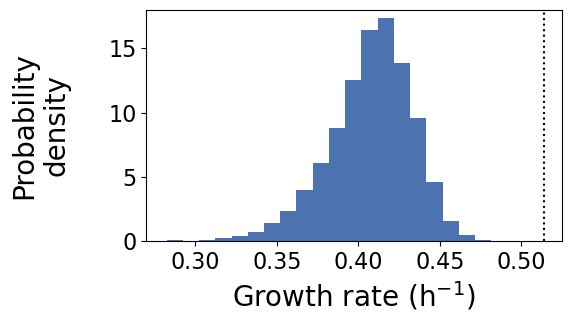

In [6]:
plt.figure( figsize=(6,3.5) )

plt.hist(f, bins=20, density=True);
plt.vlines(wt_growthrate, 0, 100,'k', ls=':')
plt.xlabel('Growth rate (h$^{-1}$)')
plt.ylabel('Probability\ndensity\n')
plt.ylim(0,18)
plt.xlim( 0.27, 0.525)

plt.tight_layout();

### [plot] Genetic variability induces variation in many metabolic fluxes

In [7]:
import escher
from escher import Builder

MIN_FLUX = 1e-10


#====== SIMPLIFIED ESCHER MAP ======#
# First prepare the vector of flx labels that we want to display...
flx_labels = {}
_ = [ flx_labels.update({ key : 0} ) for key, value in wt_solution.fluxes.items() ]

# ... color will be proportional to flux variability found in the solutions
# ... to the coefficient of variation
# ... add the correct sign
Y = np.std( np.abs(J) , axis=0) / np.mean( np.abs(J), axis=0)
Y = np.log10(0.1+abs(Y))

print( "min/max : %1.1f , %1.1f" % ( np.nanmin( Y), np.nanmax( Y)) )

Y -= np.nanmin(Y)     # place inf lim of color scale at 0
Y[ np.isnan(Y)] = 0   # get rid of nans
Y = Y*np.sign( np.mean( J, axis=0)) # add correct direction of flxes


for key, _ in flx_labels.items():
    if key in Q.NEX_RXNS:
        idx = np.argwhere( key == Q.NEX_RXNS )[:,0][0]
        flx_labels.update( {key : Y[idx] } )
        
        # If the reaction has little variability but it's typically active...
        #if Y[idx] < MIN_FLUX and np.mean(np.abs(J[:,idx]))>MIN_FLUX :
        #    flx_labels.update( {key : MIN_FLUX } )

            
            

## Load escher map ##
builder = Builder( map_name='iMM904.Central carbon metabolism' )
builder.model = cobra.io.load_json_model('./metabolic_models/%s.json' % MODEL_NAME)
builder.reaction_data = flx_labels

# Simplify the map by hiding some labels
builder.highlight_missing = False
builder.hide_secondary_metabolites = False
builder.hide_all_labels = True
builder.show_gene_reaction_rules = False
builder.reaction_scale = [
    { 'type': 'min', 'color': '#000000', 'size': 1 },                      #... inactive reactions
    { 'type': 'value', 'value':1e-20, 'color': colors[0], 'size': 25 },    #... active reactions
    { 'type': 'value', 'value':1e-10, 'color': colors[0], 'size': 25 },    #... lower lim 
    { 'type': 'max', 'color': colors[2], 'size': 25 }                      #... upper lim
]

builder

min/max : -1.0 , 2.0


Builder(hide_all_labels=True, hide_secondary_metabolites=False, highlight_missing=False, reaction_data={'EX_me…

## 2. Compute Phenotypic Prediction Score by OLS and by LASSO and...

In [8]:
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error


EXPORT_PPS= False                       #...
NTRAIN    = np.min((5_000, SAMPLES))    #... int 5000; training population size
FILENAME_PPS = 'Data_2_PPS_def_std.npz'

# Prepare population before fitting,
#... i.e. subtract the mean, but store it.
train_idx = np.arange(0, NTRAIN )

X0= np.nanmean( G[train_idx,:], axis = 0 )
y0= np.nanmean( f[train_idx] )

X = G[train_idx,:] - X0
y = f[train_idx]   - y0


print('Training set size %d' % X.shape[0])
print('Number of predictors %d' % X.shape[1])


####################################
#========= OLS REGRESSION =========#
ols = LinearRegression(fit_intercept = False, normalize = False, positive=False).fit(X , y)
ols_ypred = ols.predict(X)

ols_coef  = ols.coef_
ols_R2    = r2_score(y, ols_ypred)
ols_rmse  = mean_squared_error(y, ols_ypred, squared=False)

print('')
print('#========= OLS REGRESSION =========#')
print('R2 = %1.4f' % ols_R2 )
print('Non-null predictors %d' % np.sum( ols_coef != 0 ) )
print('RMSE = %1.4f' % ols_rmse)


####################################
#======== LASSO REGRESSION ========#
lasso = LassoCV(fit_intercept = False , positive= False ).fit(X, y)
lasso_ypred = lasso.predict(X)

lasso_coef  = lasso.coef_
lasso_R2    = r2_score(y, lasso_ypred)
lasso_rmse  = mean_squared_error(y, lasso_ypred, squared=False)
lasso_alpha = lasso.alpha_

print('')
print('#======== LASSO REGRESSION ========#')
print('R2 = %1.4f' % lasso_R2 )
print('Non-null predictors %d' % np.sum( lasso_coef != 0 ) )
print('RMSE = %1.4f' % lasso_rmse)
print('Optimal alpha is %1.3e' % lasso_alpha)


if EXPORT_PPS:
    exportable_data = {}
    #...
    exportable_data.update( {'G_std' : G[train_idx,:] } ) #... genotype matrix
    exportable_data.update( {'f_std' : f[train_idx] } )   #... true fitness values from FBA
    exportable_data.update( {'J_std' : J[train_idx,:] } ) #... fluxes of all solutions
    #... 
    exportable_data.update( {'B_std' : lasso_coef } ) #... effect sizes
    exportable_data.update( {'R2_std': lasso_R2 } )   #... R2
        
        
    np.savez(FILENAME_PPS, **exportable_data)
    print('')
    print('Data exported! ', datetime.now() )

Training set size 5000
Number of predictors 750

#========= OLS REGRESSION =========#
R2 = 0.3767
Non-null predictors 750
RMSE = 0.0203

#======== LASSO REGRESSION ========#
R2 = 0.2694
Non-null predictors 82
RMSE = 0.0220
Optimal alpha is 3.167e-05


## ... load PPS results

In [9]:
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error

FILENAME_PPS = 'Data_2_PPS_def_std.npz'

data = np.load( FILENAME_PPS )
G_std    = data['G_std'] #... genotypes
J_std    = data['J_std'] #... fluxes
f_std    = data['f_std'] #... growth_rate
coef_std = data['B_std']  #... Effect size
R2_std   = data['R2_std'] #... PPS R2


SAMPLES = G_std.shape[0]

print('Data laoded.')
print('# samples:\t%d' % SAMPLES )
print('R2 of PPS: \t%1.4f' % R2_std )


Data laoded.
# samples:	5000
R2 of PPS: 	0.2694


#### [plot] Overall prediction

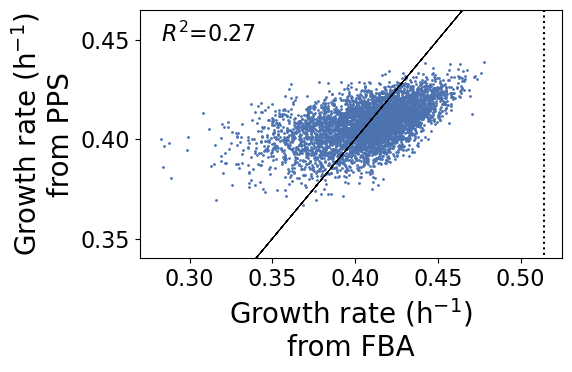

In [10]:
# Prepare population before fitting,
#... i.e. subtract the mean, but store it.
X0= np.nanmean( G_std, axis = 0 )
y0= np.nanmean( f_std )

X = G_std - X0
y = f_std - y0
ypred = np.matmul(X, coef_std)


xlim = [0.27, 0.525]
ylim = [0.34, 0.465] # xlim.copy() #


plt.figure( figsize=(6,4))

plt.plot(y+y0, ypred+y0,'.', alpha=1.0, ms=2)
plt.plot(y+y0,y+y0,'k', lw=0.5)
plt.xlim( *xlim )
plt.ylim( *ylim )

xinf, xsup = plt.xlim()
yinf, ysup = plt.ylim()

xtext = xinf + 0.051*(xsup-xinf)
ytext = yinf + 0.87*(ysup-yinf)
plt.text(xtext, ytext, '$R^2$=%1.2f' % R2_std)

plt.vlines(wt_growthrate, 0, 100,'k', ls=':')


plt.xticks( ticks= np.arange(0,0.7,0.05))
plt.yticks( ticks= np.arange(0,0.7,0.05))

plt.xlabel('Growth rate (h$^{-1}$)\nfrom FBA')
plt.ylabel('Growth rate (h$^{-1}$)\nfrom PPS')
plt.xlim( *xlim )
plt.ylim( *ylim )

plt.tight_layout();

## 3. To what extent does our PPS overfit the training set?
Montecarlo to obtain $R^2_{ts}$

In [11]:
from multiprocessing import Pool

## Load larger population as test set
data = np.load( 'Data_2_default_standard_population_50k.npz' )
G_test = data['G_std'] #... genotypes
J_test = data['J_std'] #... fluxes
f_test = data['f_std'] #... growth_rate
#... clear population from nans
f_test, G_test, J_test = Q.clear_population(f_test, [G_test,J_test], minimal_gr=1e-2)



MCMAX = 10_000           #... int 2_000; number of samples of bootstrapping
NTEST = G_std.shape[0]  #... int; size of test pop, typically equal size as the training
MAX_SIZE = G_test.shape[0]

print('Test set max size: ', MAX_SIZE)
print('Test set pop size: ', NTEST )


# Allocate output variables
R2_mc2_lasso = np.zeros(MCMAX)


def parallel(dummy):
    np.random.seed()
    
    # Randomly select a NTEST individuals among the entire population in MAX_SIZE (f,G)
    rr_test = np.random.randint( 0, MAX_SIZE, NTEST)

    # Obtain the test population genotypes and true fitness
    X_mc2 = G_test[rr_test,:] - np.mean( G_test[rr_test,:], axis=0) 
    y_mc2 = f_test[rr_test]   - np.mean( f_test[rr_test] )
    y0_mc2= np.mean( f_test[rr_test] )

    # Predict test population using the PPS computed previously
    _y_lasso = np.matmul(X_mc2, coef_std) 
    
    return r2_score(y_mc2, _y_lasso)


with Pool(50) as p, tqdm(total=MCMAX) as pbar:
    it = p.imap_unordered( parallel, range(MCMAX), chunksize=10 )
    h  = 0
    for results in it:
        R2_mc2_lasso[h] = results
        h+=1
        pbar.update(1)


Zobs_lasso = (R2_std-np.mean(R2_mc2_lasso))/np.std(R2_mc2_lasso)

print('#======== LASSO REGRESSION ========#')
print('Mean R2 = %1.4f +/- %1.4f' % (np.mean(R2_mc2_lasso), np.std(R2_mc2_lasso)) )
print('Z_obs = %1.2f' % Zobs_lasso )
print(' pval = %1.4f' % np.mean(R2_mc2_lasso>= R2_std))
print('Finished the ', datetime.now() )
print('')


 <W> Clearing 2 individuals from the population
Test set max size:  49998
Test set pop size:  5000


100%|██████████| 10000/10000 [02:54<00:00, 57.24it/s]


#======== LASSO REGRESSION ========#
Mean R2 = 0.2441 +/- 0.0091
Z_obs = 2.77
 pval = 0.0031
Finished the  2022-05-15 12:12:23.388249



#### [plot] How good is our PPS at capturing different test sets?

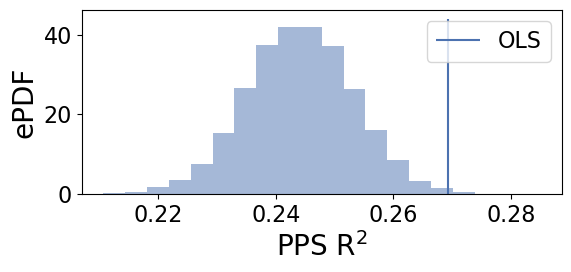

In [12]:
plt.figure( figsize=(6,3) )

h1=plt.hist(R2_mc2_lasso, bins=20, alpha=0.50, density=True)

yinf, ysup = plt.ylim()
plt.vlines(R2_std, 0, ysup, color= h1[2][0].get_facecolor()[:3] )

plt.legend(('OLS',))
plt.xlabel("PPS R$^2$") #for different test sets\n by bootstrapping, subsample size 10.000
plt.ylabel('ePDF')

plt.tight_layout();

## 4. How are effect sizes distributed?

#### The distribution of effect sizes is bimodal, we thus select a threshold of $\beta=0.01$

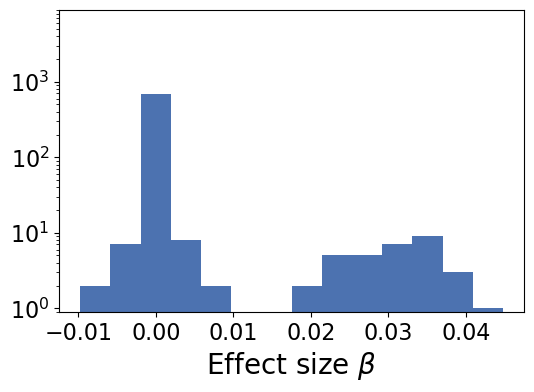

In [13]:
xx = np.linspace( np.min(coef_std), np.max(coef_std), 15)

plt.figure( figsize=(6,4) )
plt.hist(coef_std, bins=xx)
plt.yscale('log')
plt.xlabel(r'Effect size $\beta$')
plt.yscale('log')
plt.ylim(0.9,9000)
plt.yticks( ticks=(1,10,100,1000));

### Therefore one can distinguish a subset that is particularly large

In [14]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

B_THRESHOLD =0.01 


#... find genes with large/small effect
large = np.argwhere(  B_THRESHOLD < np.abs(coef_std) )[:,0]
small = np.argwhere(  [ 0<np.abs(value)<B_THRESHOLD for value in coef_std] )[:,0]

#... sort the genes with descending effect size
large_ord = coef_std[large].argsort()[::-1]
small_ord = coef_std[small].argsort()[::-1]

#... concatenate both sets of large and small
values  = np.concatenate( (coef_std[large[large_ord]],coef_std[small[small_ord]]) )
indices = np.concatenate( (large[large_ord], small[small_ord]) )
labels=[ Q.model.genes[idx].name for idx in indices ]

#... compute R2 with only large/small effect
ypred_large = np.matmul( G_std[:,large]-np.mean(G_std[:,large], axis=0) , coef_std[large] )
large_R2 = r2_score(f_std-np.mean(f_std), ypred_large)

print('N_total   = %d' % len(values) )
print('  N_large = %d' % len(large) )
print('  N_small = %d' % len(small) )
print('  N_null = %d' % (Q.N_GENES-len(large)-len(small) ) )
print('')
print('R2_total = %1.4f' % R2_std)
print('R2_large = %1.4f' % large_R2)

N_total   = 82
  N_large = 32
  N_small = 50
  N_null = 668

R2_total = 0.2694
R2_large = 0.2555


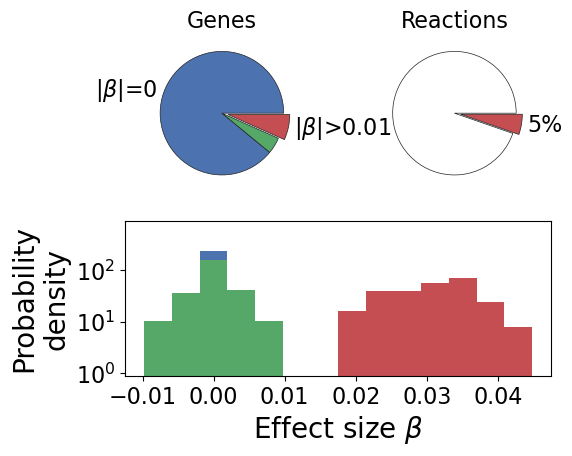

In [15]:
c_lbls = np.zeros(coef_std.shape)
c_lbls[ abs(coef_std)>0.00] = 2
c_lbls[ abs(coef_std)>0.01] = 1

I = np.argsort(coef_std)



Y1 = [np.sum(c_lbls==idx) for idx in range(3)]

plt.figure( figsize=(5.5,4.5))
plt.subplot(2,2,1)
plt.pie(Y1,
        center=(0,0),
        wedgeprops = {'edgecolor': '#222222', 'linewidth':0.5},
       explode=(0,0,0.1),
       labels=(r'|$\beta$|=0', '',r'|$\beta$|>0.01')  );
plt.title('Genes')

plt.subplot(2,2,2)
plt.pie((1148-61, 61), 
        wedgeprops = {'edgecolor': '#222222', 'linewidth':0.5},
        labels=( '',r'5%'),
        colors=['#FFFFFF', colors[2]],
        explode=(0,0.1))
plt.title('Reactions')



plt.subplot(2,2,(3,4))
xx = np.linspace( np.min(coef_std), np.max(coef_std), 15)
plt.hist(coef_std, bins=xx, density=True)
plt.hist(coef_std[small], bins=xx,density=True)
plt.hist(coef_std[large], bins=xx,density=True)
plt.xlabel(r'Effect size $\beta$')
plt.ylabel('Probability\ndensity')
plt.yscale('log')
plt.yticks( ticks=(1,10,100,1000))
plt.ylim(0.9,900);


### How many reactions do large predictors control?

In [16]:
all_rxns = []
for ii in large:
    #For every gene, I need to check their reactions...
    list_rxns = [rxn for rxn in Q.model.genes[ii].reactions]
    all_rxns.append(list_rxns)

top_rxns = [ i for b in all_rxns for i in b ]
print('The large effect %d genes rule a total of: %d reactions, of which %d are unique:' % 
     (len(large), len(top_rxns), len(set(top_rxns))))

rxn_ids = np.array([rxn.id for rxn in set(top_rxns)])
rxn_ids.sort()
#_=[print('-> ', rxn) for rxn in rxn_ids] #... uncomment to print the list of reactions


all_rxns = []
for ii in small:
    #For every gene, I need to check their reactions...
    list_rxns = [rxn for rxn in Q.model.genes[ii].reactions]
    all_rxns.append(list_rxns)

top_rxns = [ i for b in all_rxns for i in b ]
print('The small effect %d genes rule a total of: %d reactions, of which %d are unique.' % 
     (len(small), len(top_rxns), len(set(top_rxns))))

rxn_ids = np.array([rxn.id for rxn in set(top_rxns)])
rxn_ids.sort()
#_=[print('-> ', rxn) for rxn in rxn_ids] #... uncomment to print the list of reactions

The large effect 32 genes rule a total of: 107 reactions, of which 61 are unique:
The small effect 50 genes rule a total of: 95 reactions, of which 88 are unique.


### The small number of predictors is certainly linked to the small number of active reactions and genes.

In [17]:
#.......................        
# Gene-reactions matrix
GxR = np.zeros((Q.N_GENES, Q.N_NEX_RXNS))
for jj, geneid in enumerate( Q.GENES ):
    generxns = Q.model.genes.get_by_id(geneid).reactions
    for rxn in generxns:
        rxnidx = np.argwhere( rxn.id == Q.NEX_RXNS )[0][0]
        GxR[jj, rxnidx] = 1



J_min = 1e-10
wt_fluxes = np.array( [wt_solution.fluxes[geneid] for geneid in Q.NEX_RXNS])


# Compute the number of active fluxes in every individual
active_fluxes = np.sum( np.abs(J_std)>J_min, axis=1)
wt_act_fluxes = np.sum( np.abs(wt_fluxes)>J_min)

# Compute the number of active genes in every individual
active_genes = np.sum( np.matmul(GxR, np.abs(J_std).T )>J_min , axis=0)
wt_act_genes = np.sum( np.matmul(GxR, np.abs(wt_fluxes))>J_min )



print(active_fluxes.shape, active_genes.shape)
print('WT number of active fluxes %d' % wt_act_fluxes)
print('WT number of active genes  %d' % wt_act_genes)

print('Mean number of active fluxes per individual %1.1f +/- %1.1f' % (np.mean(active_fluxes), np.std(active_fluxes) ) )
print('Mean number of active genes  per individual %1.1f +/- %1.1f' % (np.mean(active_genes ), np.std(active_genes) ) )


(5000,) (5000,)
WT number of active fluxes 297
WT number of active genes  337
Mean number of active fluxes per individual 300.7 +/- 6.6
Mean number of active genes  per individual 350.7 +/- 5.7


## 5. Supplementary figures

#### ... compute important matrices ...

In [18]:
#.......................        
# Gene-reactions matrix
GxR = np.zeros((Q.N_GENES, Q.N_NEX_RXNS))
for jj, geneid in enumerate( Q.GENES ):
    generxns = Q.model.genes.get_by_id(geneid).reactions
    for rxn in generxns:
        rxnidx = np.argwhere( rxn.id == Q.NEX_RXNS )[0][0]
        GxR[jj, rxnidx] = 1


#..................................        
# Gene-biomass *precursors* matrix
biomass_rxn =  Q.model.reactions.get_by_id( Q.BIOMASS_ID )
biomass_mtb       = [ mtb      for mtb, value in biomass_rxn.metabolites.items() if value<0]
biomass_mtb_id    = np.array( [ mtb.id   for mtb in biomass_mtb ] )
biomass_mtb_name  = np.array( [ mtb.name for mtb in biomass_mtb ] )

GxB  = np.zeros( (Q.N_GENES,len(biomass_mtb)) )
GxB_ = np.zeros( (Q.N_GENES,len(biomass_mtb)) )
GxB__ = np.zeros( (Q.N_GENES,len(biomass_mtb)) )
for idxgene, geneid in enumerate(Q.GENES):
    for rxn in Q.model.genes.get_by_id(geneid).reactions:
        for mtb, value in rxn.metabolites.items():
            if mtb.id in biomass_mtb_id:
                idxmtb = np.argwhere( mtb.id == biomass_mtb_id)[0][0]
                GxB[idxgene, idxmtb]  += value
                GxB_[idxgene, idxmtb] += np.sign(value)
                GxB__[idxgene, idxmtb] += 1


#..................................        
# Reaction-biomass *precursors* matrix
NMTB= len(Q.model.metabolites)
RxB = np.zeros((Q.N_NEX_RXNS, NMTB))
for rxn_idx in range(Q.N_NEX_RXNS):
    rxn = Q.model.reactions.get_by_id( Q.NEX_RXNS[rxn_idx] )
    for mtb, CS in rxn.metabolites.items():
        if mtb.id in biomass_mtb_id:
            mtb_idx = np.argwhere( mtb.id == biomass_mtb_id )[0][0]
            RxB[ rxn_idx, mtb_idx ] += CS
            
            
        
#.............................        
# Define conversion functions
rxn2mtb  = lambda REACTION:   [mtb for mtb in REACTION.metabolites ]
rxn2gene = lambda REACTION:   [gene for gene in REACTION.genes ]
mtb2rxn  = lambda METABOLITE: [rxn for rxn in METABOLITE.reactions ]
gene2rxn = lambda GENE:       [rxn for rxn in GENE.reactions]

#### [Supplementary Figure] Plot of flux variability

In [19]:
### Compute current bounds, and sort them ###
ub = np.array( [ Q.upper_bounds[rxnid] for rxnid in Q.NEX_RXNS ] )
lb = np.array( [ Q.lower_bounds[rxnid] for rxnid in Q.NEX_RXNS ] )
I = np.argsort(ub)[::-1]

# Reactions controlled by top predictors, boolean array
large_rxns = np.matmul( GxR.T, 1*(coef_std>0.01) )>0
grr_rxns   = np.matmul( GxR.T, np.ones((Q.N_GENES)))>0


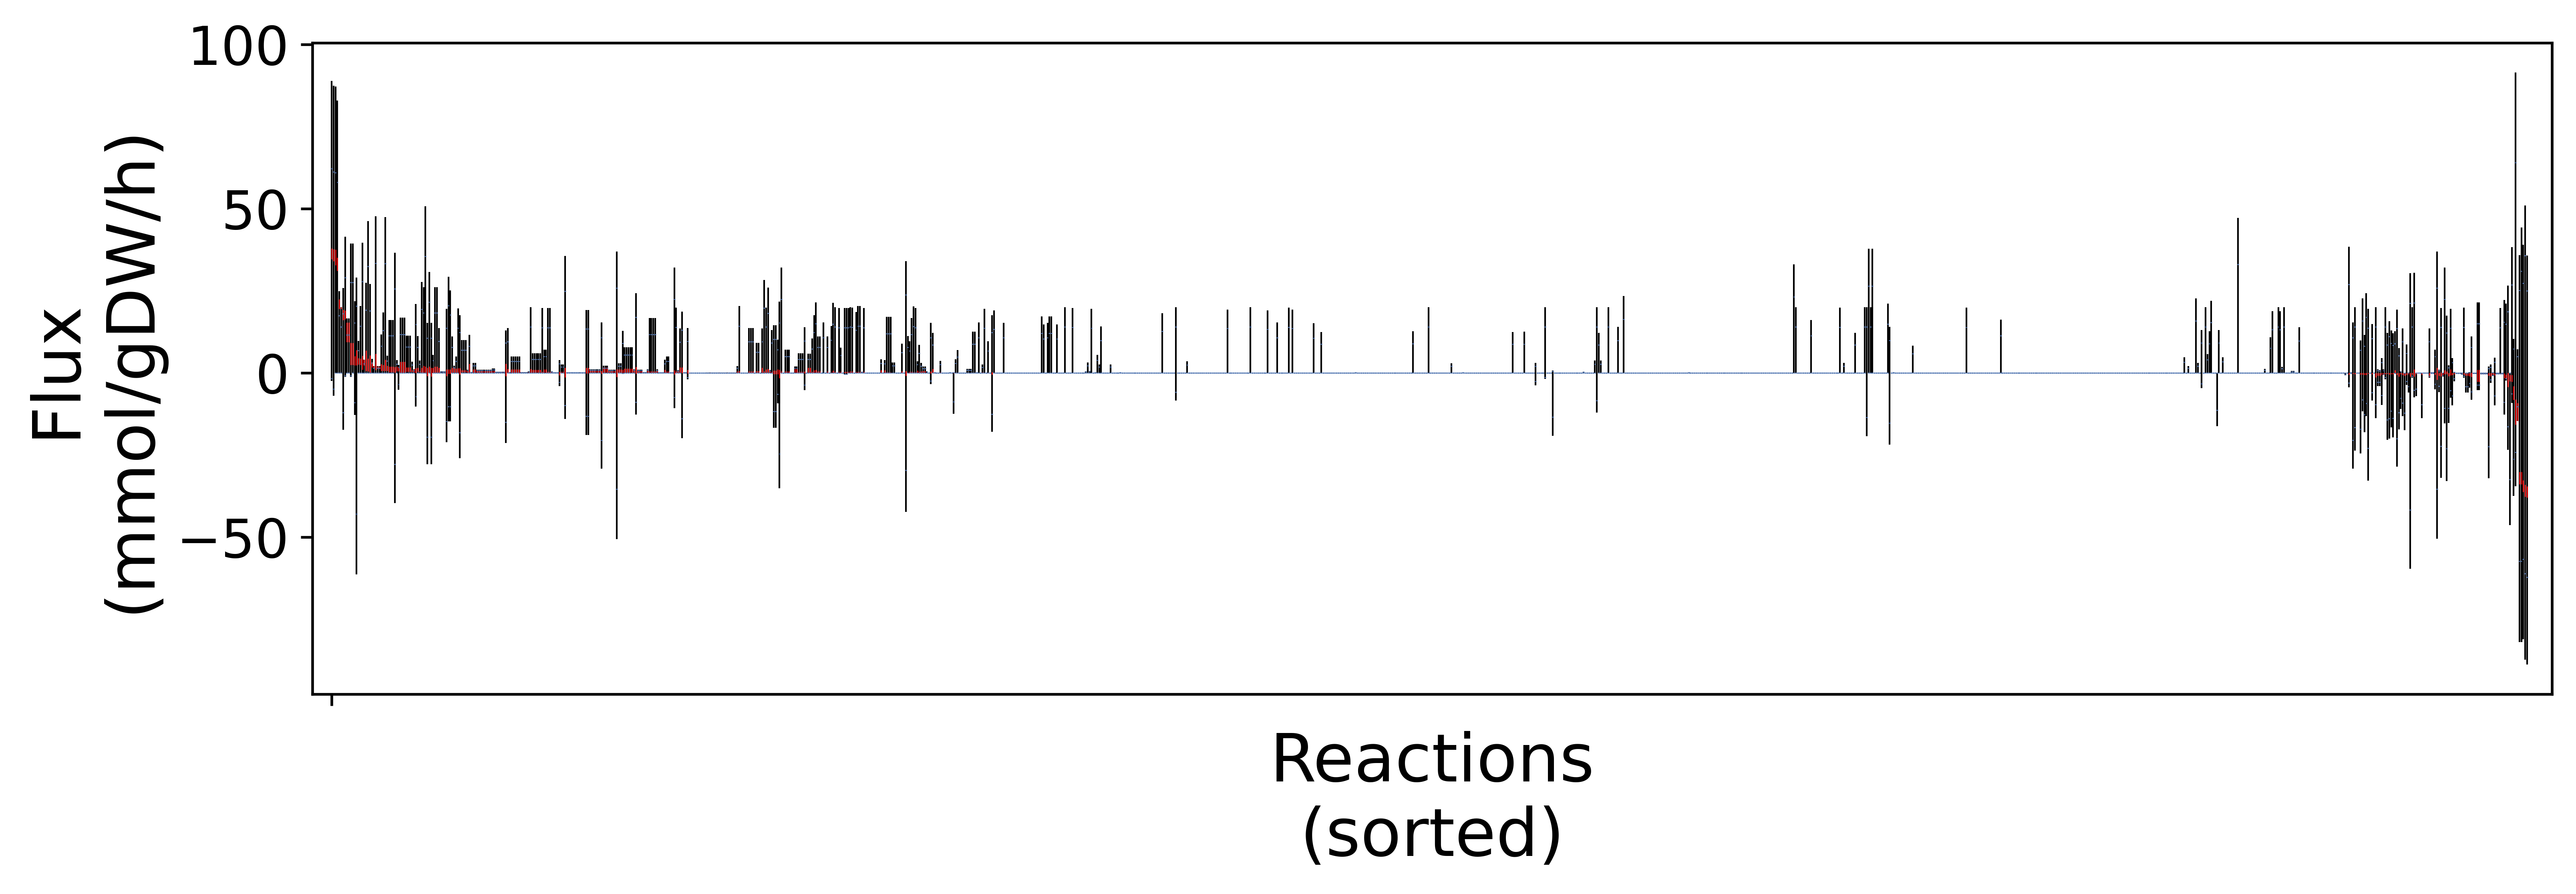

In [20]:
# For each reaction we show in black lines values of flux that are "accessible".
# In red we show the range observed in our population.

with Q.model:
    Q.reset_dosage()
    Q.apply_dosage()
    wt_solution = Q.optimize()
    wt_growthrate = wt_solution.objective_value
    wt_flx = np.array([ wt_solution.fluxes[rxn] for rxn in Q.NEX_RXNS])

I = np.argsort( np.mean(J, axis=0) )[::-1]
#I = np.argsort( (ub-lb)/2 )

plt.figure( figsize=(11,4), dpi=600 )
for jj, idx in enumerate(I):
    plt.vlines( jj, lb[idx], ub[idx] ,'k', lw=0.5)
    plt.vlines( jj, np.min(J[:,idx]), np.max(J[:,idx]), 'r', lw=0.3)
    
    plt.hlines( 0.7*ub[idx], jj-0.4, jj+0.4, color=colors[0], lw=0.3)
    plt.hlines( 0.7*lb[idx], jj-0.4, jj+0.4, color=colors[0], lw=0.3)

plt.xticks( ticks=(0,), labels='')
plt.xlim(-10,1160)

plt.xlabel('Reactions\n(sorted)')
plt.ylabel('Flux\n(mmol/gDW/h)')
plt.tight_layout();

### [Supplementary figure] Mean metabolism is a good descriptor of the population

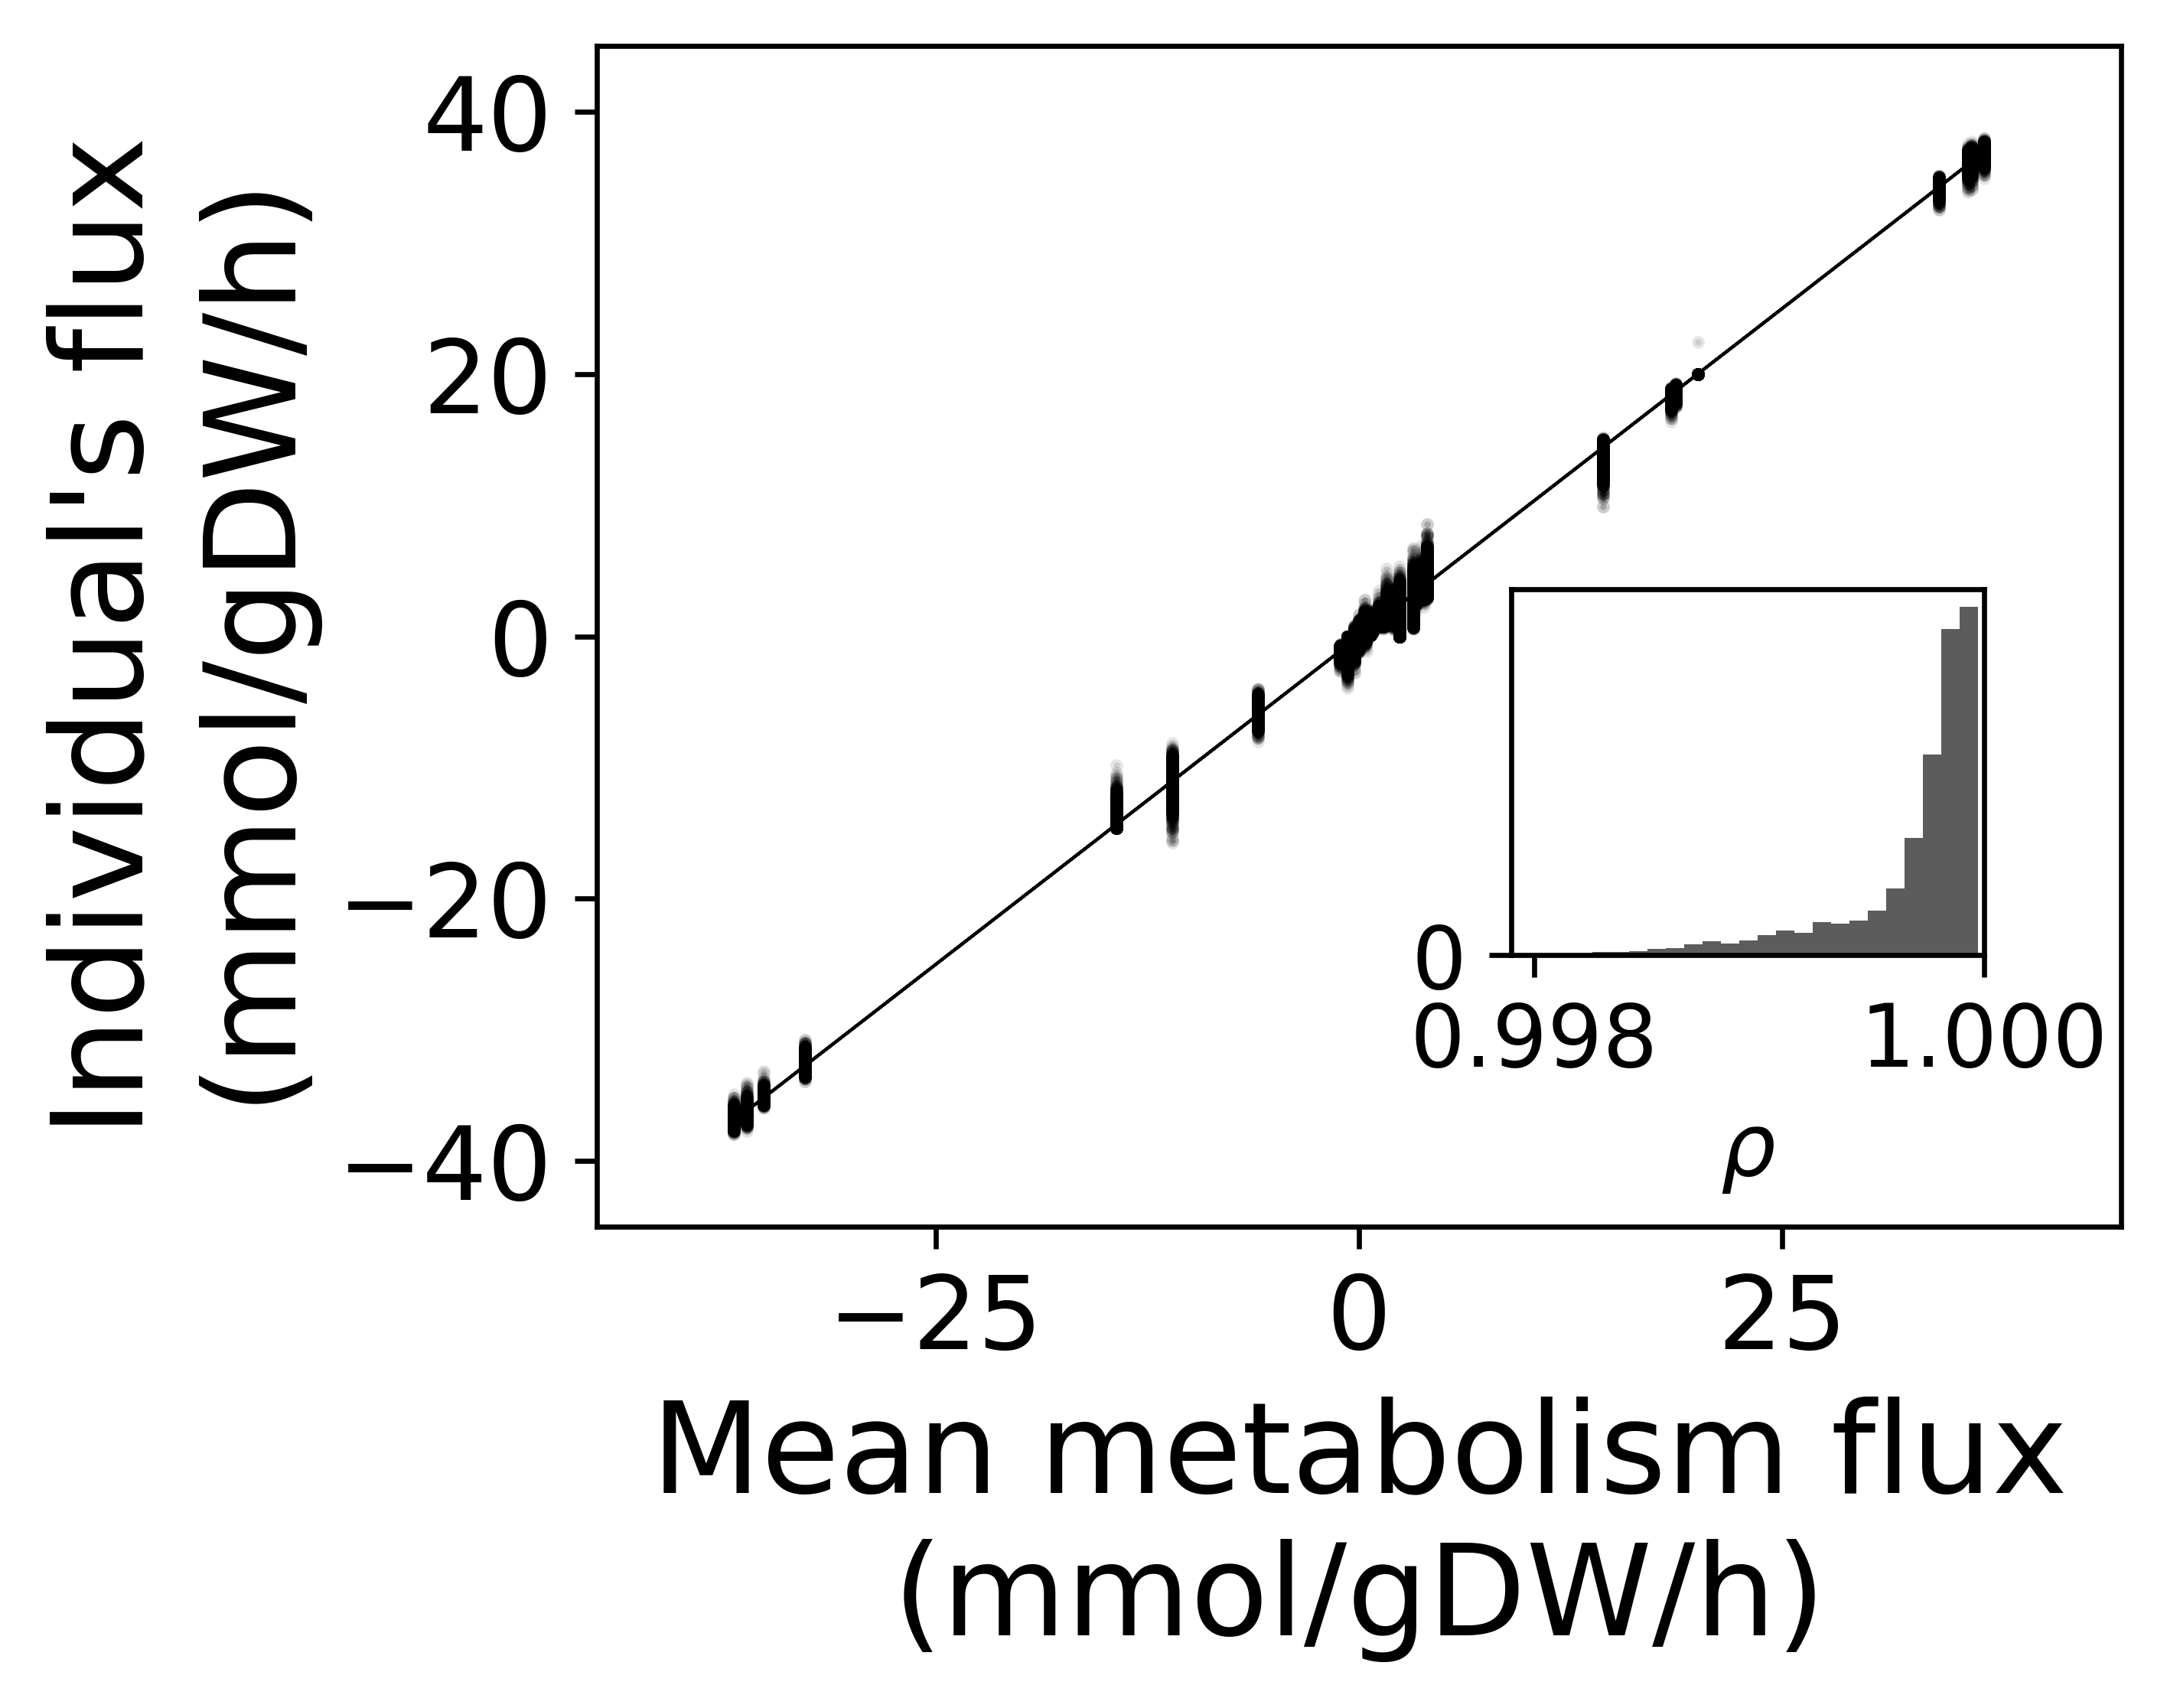

In [21]:
from matplotlib import axes

J_min = 1e-10  #... minimum flux considered
Nplots= 10   #... number of individuals to plot, it might take long if Nplots=5k 

# Compute the mean metabolism
meanJ = np.mean(J_std, axis=0)
meanJ[ abs(meanJ)<J_min ] = 0

# Compute all correlations between individuals and the mean metabolism
meanJ_corrs = np.corrcoef( np.vstack( (meanJ, J_std)))[1:,0]



plt.figure( figsize=(5,4), dpi=600 )
plt.plot( meanJ, J_std[:,:].T, '.', ms = 2, color='k', alpha=0.1)
plt.plot(meanJ, meanJ, 'k', lw=0.5)
plt.xlabel('Mean metabolism flux\n(mmol/gDW/h)')
plt.ylabel("Individual's flux\n(mmol/gDW/h)");
plt.xlim(-45, 45)
plt.ylim(-45, 45)

ax = axes.Axes.inset_axes(plt.gca(), bounds=[0.60, 0.23, 0.31, 0.31])
ax.hist( meanJ_corrs, bins=50, facecolor='#5c5c5c')
ax.set_xlabel(r'$\rho$', fontsize=0.85*SMALL_SIZE)
ax.set_xlim(0.9979, 1)
ax.tick_params(axis='x', labelsize=0.85*SMALL_SIZE )
ax.tick_params(axis='y', labelsize=0.85*SMALL_SIZE )
ax.yaxis.set_ticks((0,))

plt.tight_layout();

#### [Supplementary Figure] Full GENE-RXNS-PRECURSORS description

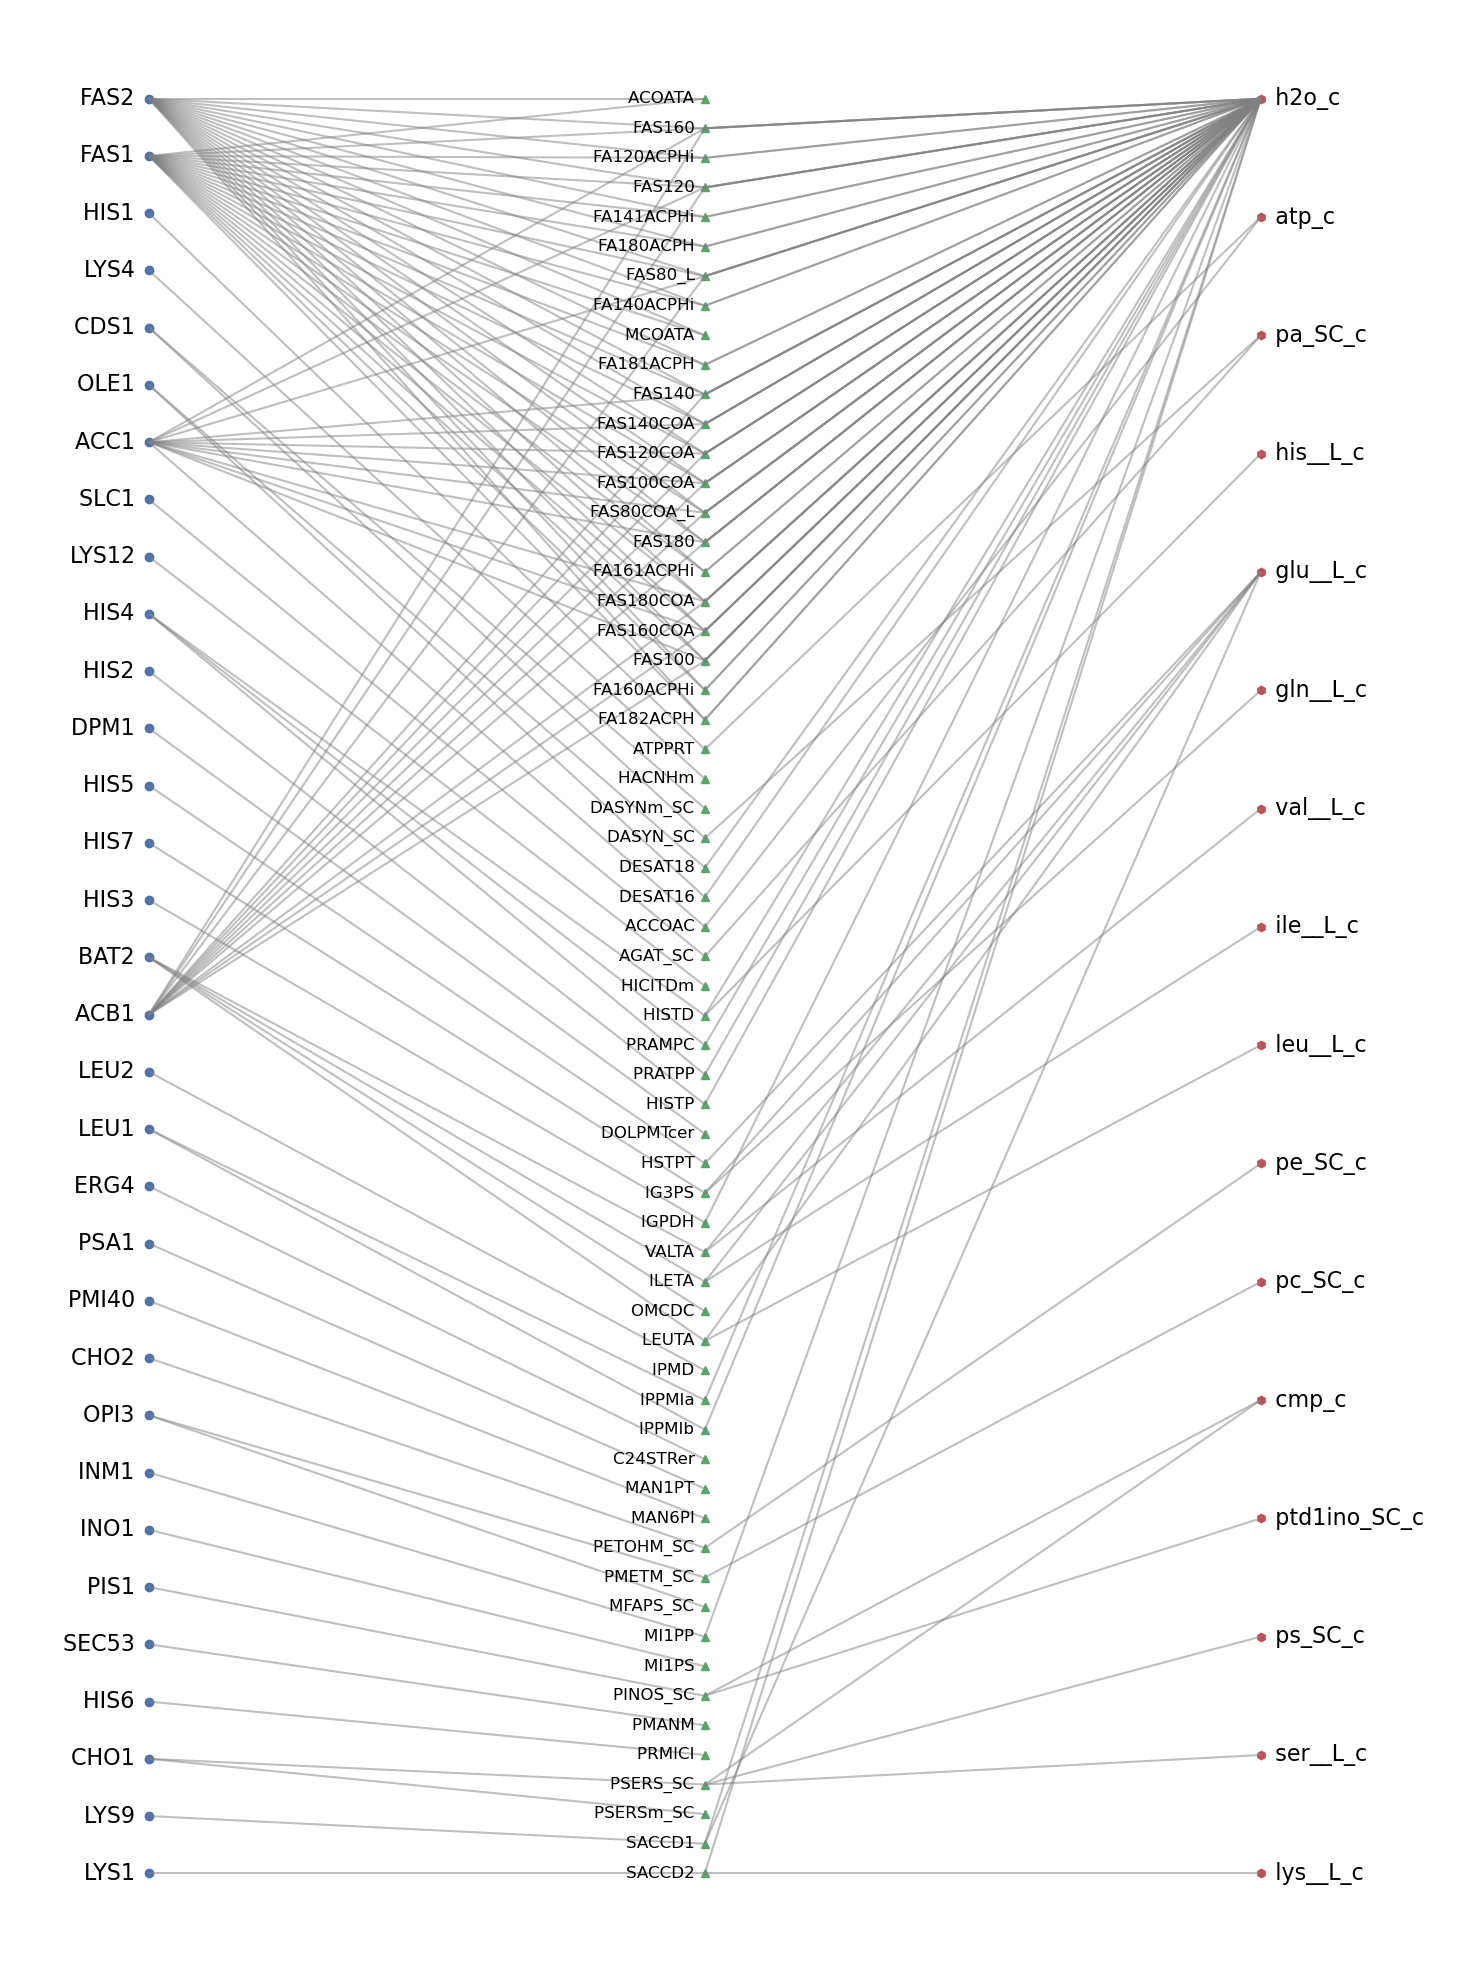

In [22]:
#..................................        
# Gene-biomass *precursors* matrix
biomass_rxn =  Q.model.reactions.get_by_id( Q.BIOMASS_ID )
biomass_mtb       = [ mtb      for mtb, value in biomass_rxn.metabolites.items() if value<0]
biomass_mtb_id    = np.array( [ mtb.id   for mtb in biomass_mtb ] )
biomass_mtb_name  = np.array( [ mtb.name for mtb in biomass_mtb ] )

GxB  = np.zeros( (Q.N_GENES,len(biomass_mtb)) )
for idxgene, geneid in enumerate(Q.GENES):
    for rxn in Q.model.genes.get_by_id(geneid).reactions:
        for mtb, value in rxn.metabolites.items():
            if mtb.id in biomass_mtb_id:
                idxmtb = np.argwhere( mtb.id == biomass_mtb_id)[0][0]
                GxB[idxgene, idxmtb]  += value
                
                
                
                
### The figure ###                
genes = np.argwhere( np.abs(coef_std)>0.01)[:,0] #indices.copy()
reactions  = []
precursors = []

color_links = 0.5*np.ones((3,))

ngenes = len(genes)-1
nreactions = np.sum( np.sum( GxR[genes,:], axis= 0) != 0)-1
nprecursors= np.sum( np.sum( GxB[genes,:], axis= 0) != 0)


plt.figure( figsize=(15,20) )
for gg, geneidx in enumerate(genes):
    gene = Q.model.genes.get_by_id( Q.GENES[geneidx] )
    x0, y0 = 0, gg/ngenes
    
    plt.plot(0, gg/ngenes ,'o', color=colors[0])
    plt.text(0, gg/ngenes, gene.name+'  ' , horizontalalignment='right', verticalalignment='center')

    
    for _, rxn in enumerate(gene.reactions):
        
        # If the reaction was not in our list, add it
        if rxn.id not in reactions:
            reactions.append(rxn.id)
            plt.plot(1, (len(reactions)-1)/nreactions,'^', color=colors[1] )
            plt.text(1, (len(reactions)-1)/nreactions, rxn.id+'  ' , horizontalalignment='right', verticalalignment='center', fontsize=0.75*SMALL_SIZE)
        
        # Draw links between genes and reactions
        rr = np.argwhere( rxn.id == np.array( reactions) )[:,0][0]
        x1, y1 = 1, rr/nreactions
        plt.plot( (x0,x1), (y0,y1),  color= color_links, alpha=0.5 )
            
        
        for _, mtb in enumerate( rxn.metabolites):
            if mtb.id in biomass_mtb_id:
                # If the metabolite is not in our list, add it
                if mtb.id not in precursors:
                    precursors.append( mtb.id)
                    plt.plot(2, (len(precursors)-1)/nprecursors,'h', color=colors[2])
                    plt.text(2, (len(precursors)-1)/nprecursors, '  '+mtb.id , horizontalalignment='left', verticalalignment='center')
                        
                # Draw links between reactions and precursors
                mm = np.argwhere( mtb.id == np.array(precursors) )[:,0][0] 
                x2, y2 = 2, mm/nprecursors
                plt.plot( (x1,x2), (y1,y2), color= color_links , alpha = 0.5 )



plt.xlim(-0.25, 2.35)
plt.gca().invert_yaxis()
plt.axis('off')
plt.tight_layout();

In [23]:
#.......................        
# Gene-reactions matrix
GxR = np.zeros((Q.N_GENES, Q.N_NEX_RXNS))
for jj, geneid in enumerate( Q.GENES ):
    generxns = Q.model.genes.get_by_id(geneid).reactions
    for rxn in generxns:
        rxnidx = np.argwhere( rxn.id == Q.NEX_RXNS )[0][0]
        GxR[jj, rxnidx] = 1


## 6. What are the limitations to predictability? (Discussion)
### 6.a We hypothesize that only part of the reactions can "read" the variability imposed by genetic variation...

In [24]:
MIN_FLUX = 1e-10

large_rxns = np.any( GxR[large,:], axis=0)
active_rxns= np.abs( np.mean( J_std, axis=0) ) > MIN_FLUX #np.any( np.abs(J_std)>MIN_FLUX, axis=0)

gc_rxns = np.any(GxR, axis=0)

max_flux = np.max(J_std, axis=0)
min_flux = np.min(J_std, axis=0)

idx_large  = np.argwhere( large_rxns)[:,0]
idx_active = np.argwhere( active_rxns)[:,0]
idx_gc     = np.argwhere( gc_rxns)[:,0]


ub = np.array( [Q.upper_bounds[rxnid] for rxnid in Q.NEX_RXNS ])
lb = np.array( [Q.lower_bounds[rxnid] for rxnid in Q.NEX_RXNS ])

wt_fluxes = np.array([wt_solution.fluxes[rxnid] for rxnid in Q.NEX_RXNS])



##### subselect across active reactions
wt_fluxes_active = wt_fluxes[idx_active]
ub_active        = ub[idx_active]
lb_active        = lb[idx_active]
idx_large_active = [ np.argwhere( ii==idx_active)[0,0] for ii in idx_large  if np.any(  ii == idx_active) ]



#### [plot]  Only a few reactions are "working" near the limits imposed by the wt bounds (or lower in green), among these few, most of them are being controled by predictor genes!

Number of active reactions: 452
Number of reactions close to 1: 64
Number of reactions controlled by preds: 43
Number of reactions close to 1 that
are controlled by predictors: 36


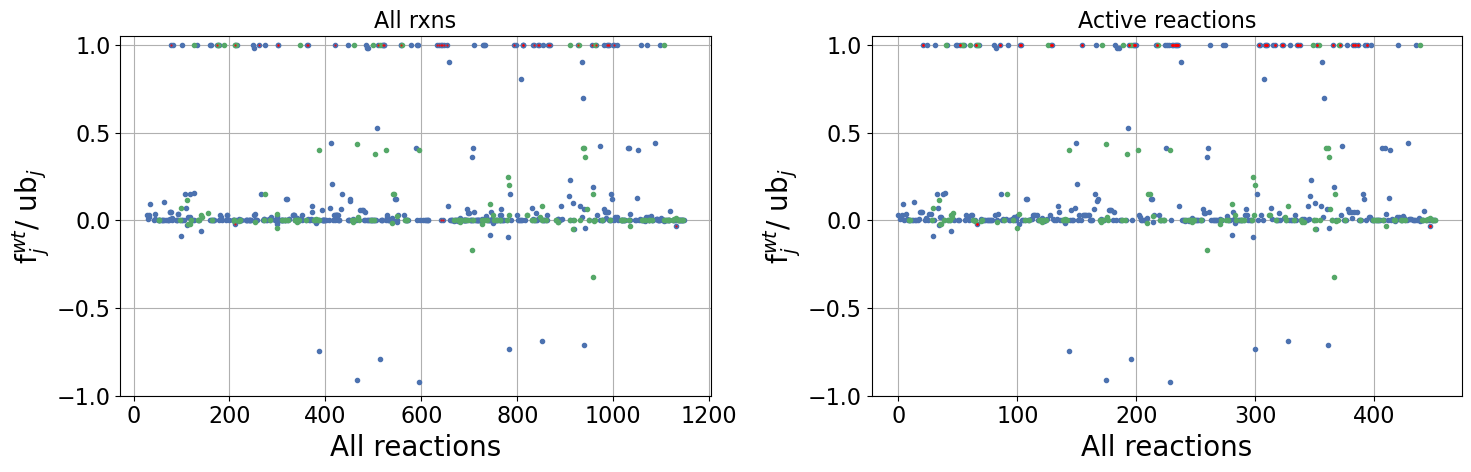

In [25]:
plt.figure( figsize=(15,5))
plt.subplot(1,2,1)
plt.plot( wt_fluxes/ub ,'.')
plt.plot( wt_fluxes/lb ,'.')
plt.plot( idx_large, (wt_fluxes/ub)[idx_large] ,'r.', ms=1)
plt.ylim(-1,1.05)
plt.ylabel('f$^{wt}_j$/ ub$_j$')
plt.xlabel('All reactions')
plt.grid();
plt.title('All rxns')

plt.subplot(1,2,2)
plt.plot( (wt_fluxes_active/ub_active) ,'.')
plt.plot( (wt_fluxes_active/lb_active) ,'.')
plt.plot( idx_large_active, (wt_fluxes_active/ub_active)[idx_large_active],'r.', ms=2)
plt.ylim(-1,1.05)
plt.ylabel('f$^{wt}_j$/ ub$_j$')
plt.xlabel('All reactions')
plt.grid()
plt.title('Active reactions')
plt.tight_layout();


RTOL = 1e-3

print('Number of active reactions:', len(idx_active))
print('Number of reactions close to 1:', np.sum( np.isclose( (wt_fluxes_active/ub_active), 1, rtol=RTOL)))
print('Number of reactions controlled by preds:', len(idx_large_active))
print('Number of reactions close to 1 that\nare controlled by predictors:', np.sum( np.isclose( (wt_fluxes_active/ub_active)[idx_large_active], 1, rtol=RTOL)))


In [26]:
###  Compare this with the null hypothesis by randomization  ####
# By randomizing which 61 reactions among active reactions
mcmax= 5000

# Observed value of the number of reactions controlled by predictors for which f_wt ~ ub
Zobs = np.sum( np.isclose( (wt_fluxes_active/ub_active)[idx_large_active], 1, rtol=RTOL))
Z_mc = np.zeros((mcmax,))

for mc in tqdm(range(mcmax)):
    idx_mc = np.random.permutation(range(len(wt_fluxes_active)))[:len(idx_large_active)]
    Z_mc[mc] = np.sum( np.isclose( (wt_fluxes_active/ub_active)[idx_mc], 1, rtol=RTOL))
    
Zscore = (Zobs - np.mean(Z_mc))/np.std(Z_mc)
print('Expected value: %1.1f +/- %1.1f' % (np.mean(Z_mc), np.std(Z_mc) ) )
print('Observed value: %d' % Zobs)
print('  its Z-score: %1.1f' % Zscore)

100%|██████████| 5000/5000 [00:01<00:00, 3132.82it/s]

Expected value: 6.1 +/- 2.2
Observed value: 36
  its Z-score: 13.7


### 6b. Then we hypothesize that, if for a couple of reactions we "manually" reduce their wt bounds, such that their reactions "can read" genetic variability, they should become growth predictors.

In [27]:
### Print reactions that are "close" to being growth limiting
LOWLIM = 0.1
UPPLIM = 0.8

potential_rxns = np.array([idx for idx in range(Q.N_NEX_RXNS) if ( LOWLIM< wt_fluxes[idx]/ub[idx] < UPPLIM ) ])

# Print reactions, reaction names and their genes' ids and names that are working close to 1 ###
for rxnidx in potential_rxns:
    print( Q.NEX_RXNS[rxnidx] , Q.model.reactions.get_by_id(Q.NEX_RXNS[rxnidx]).name )
    geneidc = np.argwhere( GxR[:, rxnidx] )[:,0]
    _=[print( '   ',Q.model.genes.get_by_id( Q.GENES[ii]).id,Q.model.genes.get_by_id( Q.GENES[ii]).name  ) for ii in geneidc ]

ADK1 Adenylate kinase
    YDR226W ADK1
ASPCTn ASPCTn
    YJL130C URA2
ASPt2n Aspartate nuclear transport via proton symport
13GS 1 3 beta glucan synthase
    YGR032W GSC2
    YLR342W FKS1
    YCR034W ELO2
    YMR306W FKS3
OMPDC Orotidine-5'-phosphate decarboxylase
    YEL021W URA3
SHK3Dr Shikimate dehydrogenase
    YDR127W ARO1
SHKK Shikimate kinase
    YDR127W ARO1
ATPS3m ATP synthase  mitochondrial
    YDR298C ATP5
    YDL181W INH1
    YBR039W ATP3
    YKL016C ATP7
    Q0085 ATP6
    YPL078C ATP4
    YJR121W ATP2
    Q0080 ATP8
    YPR020W ATP20
    YDR377W ATP17
    YDL004W ATP16
    Q0130 OLI1
    YPL271W ATP15
    YLR295C ATP14
    YBL099W ATP1
    YDR322C_A TIM11
    YOL077W_A ATP19
    YML081C_A ATP18
ATPtm_H ADPATP transporter  mitochondrial
    YBL030C PET9
    YBR085W AAC3
    YMR056C AAC1
CBPtn Carbamoyl phosphate nuclear transport via diffusion
CHORM Chorismate mutase
    YPR060C ARO7
CHORS Chorismate synthase
    YGL148W ARO2
DAGPYP_SC Diacylglycerol pyrophosphate phosphat

#### Experiment 1: among genes that, for now, are not growth predictors, modify their reactions's bounds to couple them to growth prediction.

Selected a list of reaction ids to modify their reference bounds by delta_reaction (product)


In [28]:
reaction_ids = ['PPA','TPI']      #.... those of ipp1 (YBR011C) and tpi1 (YDR050C)
delta_reaction = 0.95
reaction_idx = [ np.argwhere( Q.NEX_RXNS == rxnid )[:,0][0] for rxnid in reaction_ids ]
reaction_genes = np.array( [ gene.id for rxnid in reaction_ids for gene in  Q.model.reactions.get_by_id(rxnid).genes ])


# Load maximal bounds
Q.load_bounds('Data_1_bounds_0.10.csv')
Q.reset_dosage()
Q.apply_dosage()

#Compute WT solution
wt_solution  = Q.optimize()
wt_growthrate= Q.slim_optimize()
print('Wild-type growth rate %1.3f' % Q.slim_optimize() )
print(datetime.now())
print('')
print('-------------')

for jj in range(len(reaction_ids)):
    print('You requested to alter reaction: %s' % Q.model.reactions.get_by_id(Q.NEX_RXNS[reaction_idx[jj]]).name )
    print('The current bounds are: (%1.2f, %1.2f)' % (Q.lower_bounds[reaction_ids[jj]] , Q.upper_bounds[reaction_ids[jj]]) )
    print('... and the wt solution flux is %1.3f' % wt_fluxes[reaction_idx[jj]])

    Q.upper_bounds[reaction_ids[jj]] = delta_reaction*np.max( (0,wt_fluxes[reaction_idx[jj]]))
    Q.lower_bounds[reaction_ids[jj]] = delta_reaction*np.min( (0,wt_fluxes[reaction_idx[jj]]))

    print('The new bounds are: (%1.2f, %1.2f)' % (Q.lower_bounds[reaction_ids[jj]] , Q.upper_bounds[reaction_ids[jj]]) )
    print('-------------')


# Compute population
Q.reset_dosage()
Q.apply_dosage()
media = [std_medium for _ in range( G_std.shape[0])]


f_juan,_, J_juan,_, Ri_juan = Q.compute_population( G_std, media, nprocessors=50)



####################################
#======== LASSO REGRESSION ========#
X0= np.nanmean( G_std, axis = 0 )
y0= np.nanmean( f_juan )

X = G_std - X0
y = f_juan   - y0

lasso = LassoCV(fit_intercept = False , positive= False ).fit(X, y)
lasso_ypred = lasso.predict(X)

lasso_coef  = lasso.coef_
lasso_R2    = r2_score(y, lasso_ypred)
lasso_rmse  = mean_squared_error(y, lasso_ypred, squared=False)
lasso_alpha = lasso.alpha_

print('')
print('#======== LASSO REGRESSION ========#')
print('R2 = %1.4f' % lasso_R2 )
print('Non-null predictors %d' % np.sum( lasso_coef != 0 ) )
print('Large-effect predictors %d' % np.sum( np.abs(lasso_coef) > 0.01 ) )
print('RMSE = %1.4f' % lasso_rmse)
print('Optimal alpha is %1.3e' % lasso_alpha)

reaction_genes = np.array( [ gene.id for rxnid in reaction_ids for gene in  Q.model.reactions.get_by_id(rxnid).genes ])
reaction_genes_n = np.array( [ gene.name for rxnid in reaction_ids for gene in  Q.model.reactions.get_by_id(rxnid).genes ])

print('Total number of predictors: %d' % np.sum(lasso_coef>0.01) )
reaction_genes_idc = [ np.argwhere( gene == Q.GENES)[:,0][0] for gene in reaction_genes]
print('Genes associated to the reaction and their effect sizes:')
print('________________________')
print('Name -  New b  -  Old b ')
_= [print(' %s - %1.4f - %1.4f' % ( name, lasso_coef[idx], coef_std[idx]) ) for name, idx in zip(reaction_genes_n, reaction_genes_idc) ]

Maxbounds loaded from Data_1_bounds_0.10.csv on 2022-05-15 12:13:44.906088.
Wild-type growth rate 0.514
2022-05-15 12:13:45.141513

-------------
You requested to alter reaction: Inorganic diphosphatase
The current bounds are: (0.00, 4.26)
... and the wt solution flux is 1.799
The new bounds are: (0.00, 1.71)
-------------
You requested to alter reaction: Triose-phosphate isomerase
The current bounds are: (-1.20, 41.45)
... and the wt solution flux is 18.195
The new bounds are: (0.00, 17.29)
-------------
Computing population of 5000 samples...


100%|██████████| 5000/5000 [00:41<00:00, 121.76it/s]


Total infeasible from within 0

#======== LASSO REGRESSION ========#
R2 = 0.2724
Non-null predictors 117
Large-effect predictors 35
RMSE = 0.0217
Optimal alpha is 2.849e-05
Total number of predictors: 34
Genes associated to the reaction and their effect sizes:
________________________
Name -  New b  -  Old b 
 IPP1 - 0.0664 - -0.0000
 TPI1 - 0.0218 - 0.0000


#### Experiment 2: among genes that are growth predictors, modify their reactions's bounds to uncouple them from growth prediction.

Selected a list of reaction ids to modify their reference bounds by delta_reaction (product)

In [29]:
reaction_ids = ['ATPPRT','HISTP'] #.... those of his1 and his2
delta_reaction = 100
reaction_idx = [ np.argwhere( Q.NEX_RXNS == rxnid )[:,0][0] for rxnid in reaction_ids ]
reaction_genes = np.array( [ gene.id for rxnid in reaction_ids for gene in  Q.model.reactions.get_by_id(rxnid).genes ])


# Load maximal bounds
Q.load_bounds('Data_1_bounds_0.10.csv')

Q.reset_dosage()
Q.apply_dosage()


#Compute WT solution
wt_solution  = Q.optimize()
wt_growthrate= Q.slim_optimize()
print('Wild-type growth rate %1.3f' % Q.slim_optimize() )
print(datetime.now())
print('')
print('-------------')

for jj in range(len(reaction_ids)):
    print('You requested to alter reaction: %s' % Q.model.reactions.get_by_id(Q.NEX_RXNS[reaction_idx[jj]]).name )
    print('The current bounds are: (%1.2f, %1.2f)' % (Q.lower_bounds[reaction_ids[jj]] , Q.upper_bounds[reaction_ids[jj]]) )
    print('... and the wt solution flux is %1.3f' % wt_fluxes[reaction_idx[jj]])

    Q.upper_bounds[reaction_ids[jj]] = delta_reaction*np.max( (0,wt_fluxes[reaction_idx[jj]]))
    Q.lower_bounds[reaction_ids[jj]] = delta_reaction*np.min( (0,wt_fluxes[reaction_idx[jj]]))

    print('The new bounds are: (%1.2f, %1.2f)' % (Q.lower_bounds[reaction_ids[jj]] , Q.upper_bounds[reaction_ids[jj]]) )
    print('-------------')


# Compute population
Q.reset_dosage()
Q.apply_dosage()
media = [std_medium for _ in range( G_std.shape[0])]


f_juan,_, J_juan,_, Ri_juan = Q.compute_population( G_std, media, nprocessors=50)



####################################
#======== LASSO REGRESSION ========#
X0= np.nanmean( G_std, axis = 0 )
y0= np.nanmean( f_juan )

X = G_std - X0
y = f_juan   - y0

lasso2 = LassoCV(fit_intercept = False , positive= False ).fit(X, y)
lasso2_ypred = lasso2.predict(X)

lasso2_coef  = lasso2.coef_
lasso2_R2    = r2_score(y, lasso2_ypred)
lasso2_rmse  = mean_squared_error(y, lasso2_ypred, squared=False)
lasso2_alpha = lasso2.alpha_

print('')
print('#======== LASSO REGRESSION ========#')
print('R2 = %1.4f' % lasso2_R2 )
print('Non-null predictors %d' % np.sum( lasso2_coef != 0 ) )
print('Large-effect predictors %d' % np.sum( np.abs(lasso2_coef) > 0.01 ) )
print('RMSE = %1.4f' % lasso2_rmse)
print('Optimal alpha is %1.3e' % lasso2_alpha)

reaction_genes = np.array( [ gene.id for rxnid in reaction_ids for gene in  Q.model.reactions.get_by_id(rxnid).genes ])
reaction_genes_n = np.array( [ gene.name for rxnid in reaction_ids for gene in  Q.model.reactions.get_by_id(rxnid).genes ])

print('Total number of predictors: %d' % np.sum(lasso2_coef>0.01) )
reaction_genes_idc = [ np.argwhere( gene == Q.GENES)[:,0][0] for gene in reaction_genes]
print('Genes associated to the reaction and their effect sizes:')
print('________________________')
print('Name -  New b  -  Old b ')
_= [print(' %s - %1.4f - %1.4f' % ( name, lasso2_coef[idx], coef_std[idx]) ) for name, idx in zip(reaction_genes_n, reaction_genes_idc) ]

Maxbounds loaded from Data_1_bounds_0.10.csv on 2022-05-15 12:14:37.125337.
Wild-type growth rate 0.514
2022-05-15 12:14:37.321548

-------------
You requested to alter reaction: ATP phosphoribosyltransferase
The current bounds are: (0.00, 0.03)
... and the wt solution flux is 0.034
The new bounds are: (0.00, 3.41)
-------------
You requested to alter reaction: Histidinol-phosphatase
The current bounds are: (0.00, 0.03)
... and the wt solution flux is 0.034
The new bounds are: (0.00, 3.41)
-------------
Computing population of 5000 samples...


100%|██████████| 5000/5000 [00:42<00:00, 117.67it/s]


Total infeasible from within 0

#======== LASSO REGRESSION ========#
R2 = 0.2848
Non-null predictors 76
Large-effect predictors 30
RMSE = 0.0218
Optimal alpha is 3.232e-05
Total number of predictors: 30
Genes associated to the reaction and their effect sizes:
________________________
Name -  New b  -  Old b 
 HIS1 - 0.0000 - 0.0354
 HIS2 - -0.0000 - 0.0318


#### [plot] Plot changes in effect sizes in both experiments

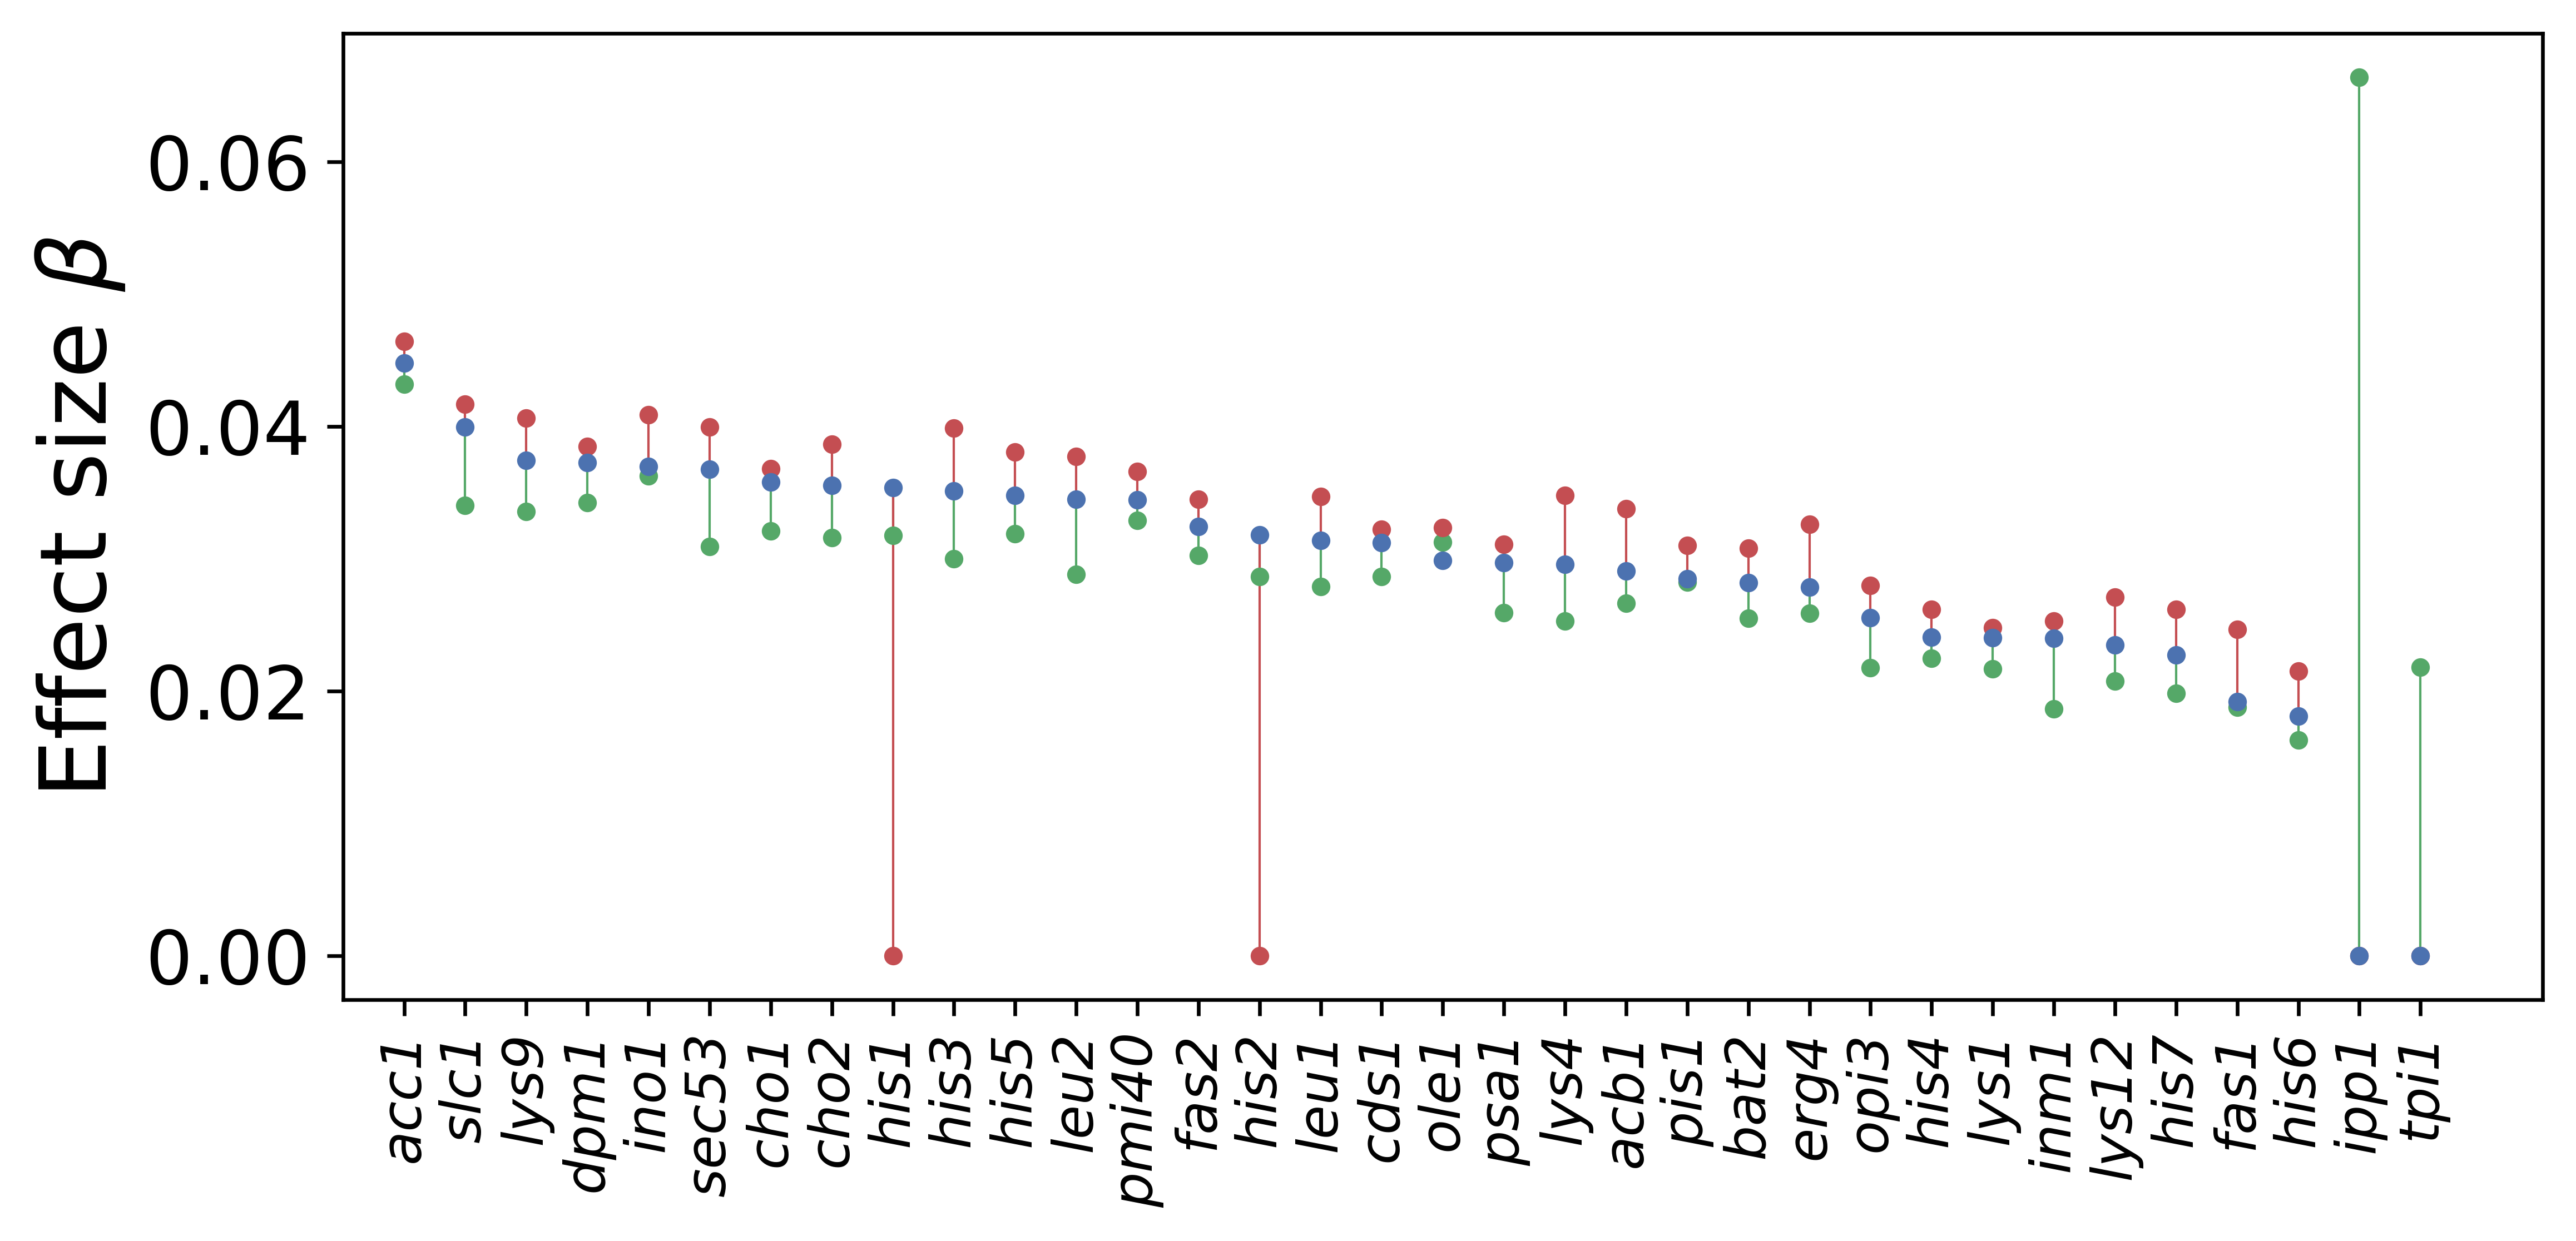

In [30]:
genes_idcs = large[large_ord].copy()
genes_idcs = np.hstack( (genes_idcs, [558,705] ))
genes_names=  [Q.model.genes.get_by_id(gid).name.lower() for gid in Q.GENES[genes_idcs]]


plt.figure( figsize=(8,4), dpi=600 )
plt.plot( range(len(genes_idcs)), coef_std[genes_idcs],'.', zorder=200)
plt.plot( range(len(genes_idcs)), lasso_coef[genes_idcs] , '.')
plt.plot( range(len(genes_idcs)), lasso2_coef[genes_idcs] ,'.')

for jj, idx in enumerate(genes_idcs):
    plt.vlines( jj, coef_std[idx], lasso_coef[idx], color=colors[1], lw=0.5)
    plt.vlines( jj, coef_std[idx], lasso2_coef[idx], color=colors[2], lw=0.5)


plt.xlim(-1, len(genes_idcs)+1)
#plt.gca().invert_yaxis()
plt.xticks( ticks= range(len(genes_idcs)), labels=genes_names,style='italic', fontsize=0.75*SMALL_SIZE, rotation=90 )
plt.ylabel(r'Effect size $\beta$');
plt.tight_layout();

#### Extra: repeat the first experiment, but with an array of delta_reaction

In [31]:
reaction_ids = ['PPA','TPI']
reaction_idx = [ np.argwhere( Q.NEX_RXNS == rxnid )[:,0][0] for rxnid in reaction_ids ]
reaction_genes = np.array( [ gene.id for rxnid in reaction_ids for gene in  Q.model.reactions.get_by_id(rxnid).genes ])
reaction_genes_n = np.array( [ gene.name for rxnid in reaction_ids for gene in  Q.model.reactions.get_by_id(rxnid).genes ])
reaction_genes_idc = [ np.argwhere( gene == Q.GENES)[:,0][0] for gene in reaction_genes]

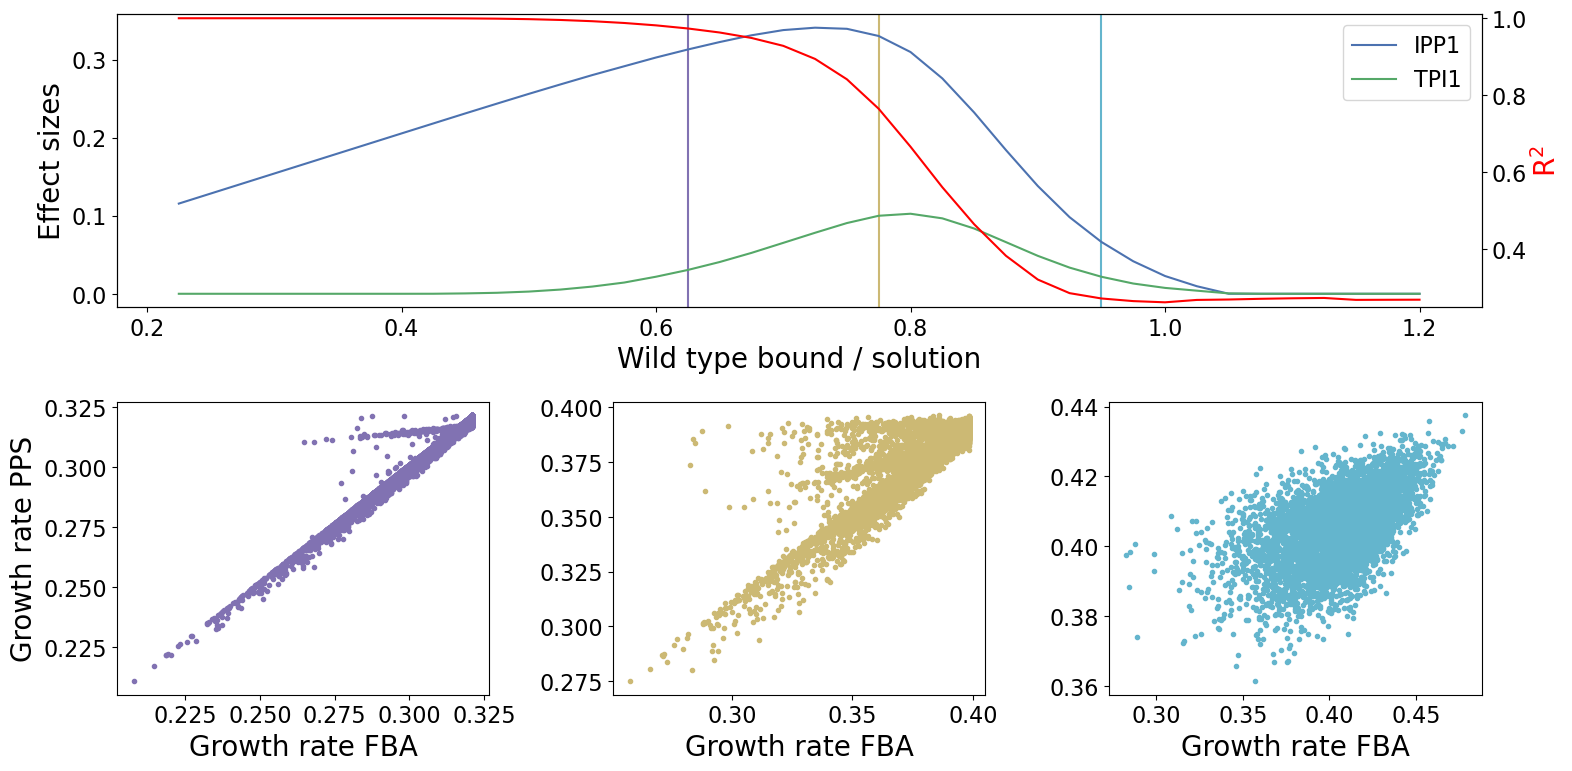

In [32]:
data = np.load('Data_Sup_Sweeps.npz' )
BETAS_sweep = data['BETAS']
R2_sweep    = data['R2']
Ytrues      = data ['Ytrues']
Ypreds      = data ['Ypreds']
delta_reaction_array = data['array']
Fluxes_sweep = data['Fluxes_sweep']

idx1= 23
idx2= 17
idx3= 10

plt.figure( figsize=(16,8) ,dpi=100)

plt.subplot(2,3,(1,3))
plt.plot(delta_reaction_array, BETAS_sweep.T)
ylim = plt.ylim()
plt.vlines( delta_reaction_array[idx1], -10, 10, color=colors[3])
plt.vlines( delta_reaction_array[idx2], -10, 10, color=colors[4])
plt.vlines( delta_reaction_array[idx3], -10, 10, color=colors[5])
plt.ylim(ylim)
plt.legend(reaction_genes_n)
plt.ylabel('Effect sizes')
plt.xlabel('Wild type bound / solution')


axR=plt.gca().twinx()
p=axR.plot( delta_reaction_array, R2_sweep, 'r') 
axR.set_ylabel("R$^2$", color='r')
axR.set_xlabel('Effect sizes')
axR.set_ylim(0.25,1.01)

plt.subplot(2,3,4)
plt.plot( Ytrues[:, idx1], Ypreds[:,idx1]-np.nanmean(Ypreds[:,idx1])+np.nanmean(Ytrues[:,idx1]),'.',
        color= colors[3])
plt.xlabel('Growth rate FBA')
plt.ylabel('Growth rate PPS')

plt.subplot(2,3,5)
plt.plot( Ytrues[:, idx2], Ypreds[:,idx2]-np.nanmean(Ypreds[:,idx2])+np.nanmean(Ytrues[:,idx2]),'.',
        color=colors[4])
plt.xlabel('Growth rate FBA')

plt.subplot(2,3,6)
plt.plot( Ytrues[:, idx3], Ypreds[:,idx3]-np.nanmean(Ypreds[:,idx3])+np.nanmean(Ytrues[:,idx3]),'.',
        color=colors[5])
plt.xlabel('Growth rate FBA')

plt.tight_layout();

## Sweeps v2. Do additional predictors improve R2?

In [33]:
### Load data ###
data  = np.load('Data_Sup_Sweeps_2_release.npz')
BETAS_sweep = data['BETAS']
R2_sweep    = data['R2']
Ytrues      = data['Ytrues']
Ypreds      =data['Ypreds']
delta_reaction_array=data['array']
Fluxes_sweep=data['Fluxes_sweep']

#### [plot] Correlation between the number of predictors and the predictability when randomly coupling/uncoupling reactions from growth prediction

Text(0, 0.5, 'Number of large effect\npredictors')

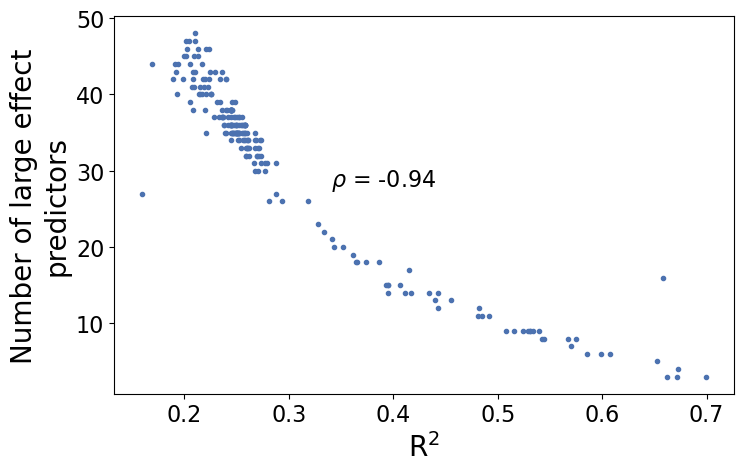

In [34]:
npreds= np.nansum( BETAS_sweep>0.01 , axis=0).astype('float64')
npreds[ npreds==0] = np.nan

idc=np.argwhere(np.isfinite(npreds))[:,0]

plt.figure( figsize=(8,5) )
plt.plot(R2_sweep, npreds,'.')
plt.text(0.34, 28, r"$\rho$ = %1.2f" % (np.corrcoef(R2_sweep[idc], npreds[idc])[0,1]) )
plt.xlabel('R$^2$')
plt.ylabel('Number of large effect\npredictors')